# DATATHON 2024

### Gerekli Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

### Eğitim Ve Test Veri Setlerinin Yüklemesi

In [2]:
train_df = pd.read_csv(r"C:\Users\Emirhan Tozlu\Desktop\kaggle yarışmaları\TriData\Veri Setleri\train.csv")
test_df = pd.read_csv(r"C:\Users\Emirhan Tozlu\Desktop\kaggle yarışmaları\TriData\Veri Setleri\test_x.csv")

C:\Users\Emirhan Tozlu\AppData\Local\Temp\ipykernel_17880\1124721049.py:1: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(r"C:\Users\Emirhan Tozlu\Desktop\kaggle yarışmaları\TriData\Veri Setleri\train.csv")


In [3]:
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

# Eksik Verilerin Yüzdeleri

In [4]:
missing_train = train_df.isna().mean() * 100
missing_train

Basvuru Yili                                             0.000000
Degerlendirme Puani                                      0.000000
Cinsiyet                                                 0.259501
Dogum Tarihi                                             0.271785
Dogum Yeri                                               1.214587
Ikametgah Sehri                                          3.127831
Universite Adi                                           0.202687
Universite Turu                                          0.391555
Burs Aliyor mu?                                          0.000000
Bölüm                                                    0.354702
Universite Kacinci Sinif                                 0.574280
Universite Not Ortalamasi                                4.227255
Lise Adi                                                 0.589635
Lise Sehir                                               1.618426
Lise Turu                                                1.300576
Lise Bolum

In [5]:
missing_test = test_df.isna().mean() * 100
missing_test

Basvuru Yili                                                   0.0
Cinsiyet                                                       0.0
Dogum Tarihi                                                   0.0
Dogum Yeri                                                     0.0
Ikametgah Sehri                                                0.0
Universite Adi                                                 0.0
Universite Turu                                                0.0
Burslu ise Burs Yuzdesi                                      100.0
Burs Aliyor mu?                                                0.0
Bölüm                                                          0.0
Universite Kacinci Sinif                                       0.0
Universite Not Ortalamasi                                      0.0
Daha Once Baska Bir Universiteden Mezun Olmus                100.0
Lise Adi                                                       0.0
Lise Adi Diger                                               1

### Eksik Verilerin Görselleştirilmesi

C:\Users\Emirhan Tozlu\AppData\Local\Temp\ipykernel_17880\1190258385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_train.index, y=missing_train.values, palette='cubehelix')


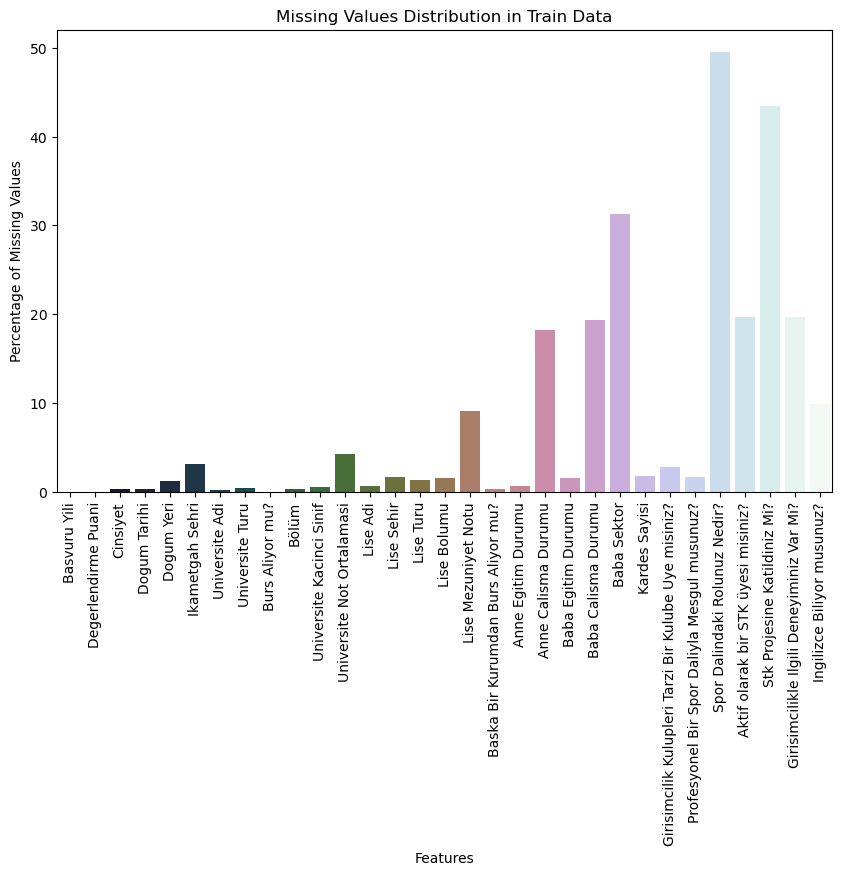

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_train.index, y=missing_train.values, palette='cubehelix')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in Train Data')
plt.show()

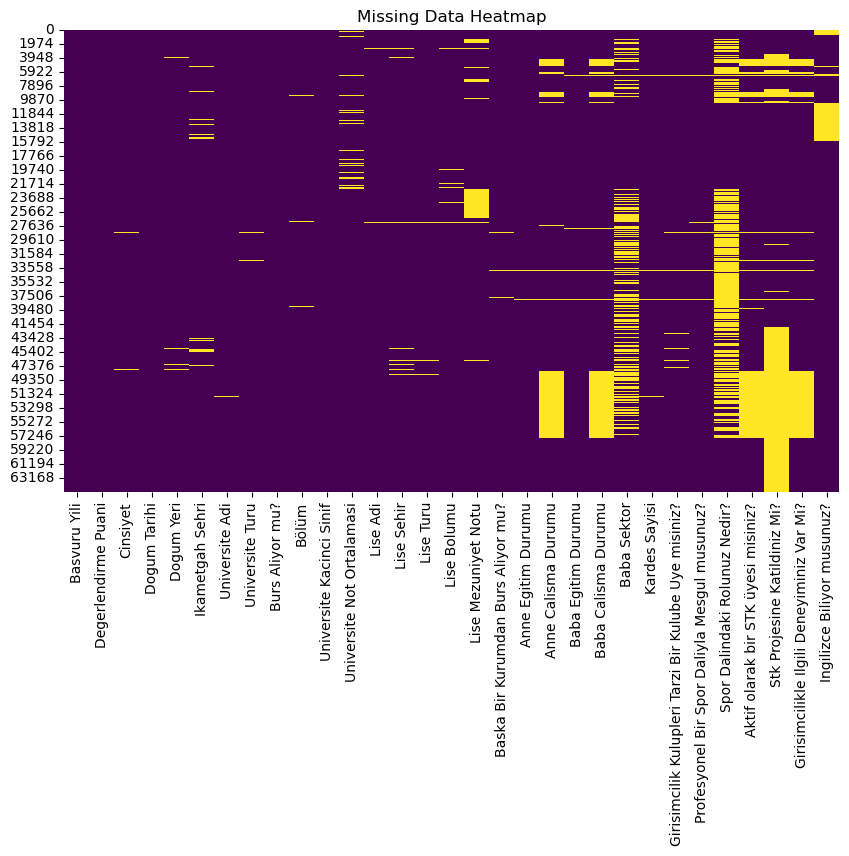

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

### Eksik Verilerin Doldurulması Ve Tür Dönüşümü

In [8]:
missing_threshold = 0.75
high_missing_columns = train_df.columns[train_df.isnull().mean() > missing_threshold]
train_df = train_df.drop(columns=high_missing_columns)
test_df = test_df.drop(columns=high_missing_columns)

In [9]:
def knn_impute(df, n_neighbors=5):
    non_empty_columns = df.columns[df.isnull().mean() < 1.0]
    df_reduced = df[non_empty_columns].copy()
    
    for col in df_reduced.select_dtypes(include='object').columns:
        df_reduced[col] = df_reduced[col].astype('category').cat.codes

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_reduced), columns=df_reduced.columns)
    
    for col in df.select_dtypes(include='object').columns:
        if col in df_reduced.columns:
            df_imputed[col] = df_imputed[col].round().astype(int).map(
                dict(enumerate(df[col].astype('category').cat.categories))
            )
    
    for col in df.columns:
        if col not in df_imputed.columns:
            df_imputed[col] = np.nan
    
    df_imputed = df_imputed[df.columns]
    
    return df_imputed

df_train_imputed = knn_impute(train_df, n_neighbors=5)
df_test_imputed = knn_impute(test_df, n_neighbors=5)

In [10]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'Degerlendirme Puani']

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

### Model Eğitimi

In [11]:
df_test_imputed = df_test_imputed.reindex(columns=df_train_imputed.columns.drop('Degerlendirme Puani'), fill_value=0)

In [12]:
y = df_train_imputed['Degerlendirme Puani']
X = df_train_imputed.drop(['Degerlendirme Puani'], axis=1)

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Özellik Ölçekleme
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [15]:
catboost_model = CatBoostRegressor(silent=True, random_state=42)
param_dist_cat = {
    'depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 1000],
    'l2_leaf_reg': [3, 5],
    'bagging_temperature': [0.8, 1.0]
}

random_search_cat = RandomizedSearchCV(estimator=catboost_model, param_distributions=param_dist_cat, 
                                       scoring='neg_root_mean_squared_error', cv=3, n_iter=10, 
                                       n_jobs=-1, random_state=42, verbose=2)
random_search_cat.fit(train_X_scaled, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001D9302E1B20>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0.8, 1.0],
                                        'depth': [6, 10],
                                        'iterations': [500, 1000],
                                        'l2_leaf_reg': [3, 5],
                                        'learning_rate': [0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [16]:
# En iyi parametreler ve performans belirlenmesi
best_params_cat = random_search_cat.best_params_
best_rmse_cat = -random_search_cat.best_score_
print(f"Best CatBoost Parameters: {best_params_cat}")
print(f"Best CatBoost RMSE: {best_rmse_cat}")

Best CatBoost Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 6, 'bagging_temperature': 1.0}
Best CatBoost RMSE: 5.5189637093890305


### Tahmin Ve Submisson Süreci

In [17]:
model_cat = random_search_cat.best_estimator_

In [18]:
test_df_scaled = scaler.transform(df_test_imputed)

In [19]:
test_pred_cat = model_cat.predict(test_df_scaled)

In [20]:
df_sub = pd.DataFrame({
    'id': pd.read_csv(r'C:\Users\Emirhan Tozlu\Desktop\kaggle yarışmaları\TriData\Veri Setleri\test_x.csv')['id'],
    'Degerlendirme Puani': test_pred_cat
})
df_sub.to_csv(r'C:\Users\Emirhan Tozlu\Desktop\kaggle yarışmaları\TriData\Veri Setleri\submission_TriDataa.csv', index=False)